In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

#### Read the datasets into dataframes

In [4]:
play_store_df = pd.read_csv("/content/googleplaystore.csv")
user_ratings_df = pd.read_csv("/content/googleplaystore_user_reviews.csv" ,encoding='utf8')

In [5]:
## Display the Play Store App data
play_store_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [6]:
## Display the User Ratings data
user_ratings_df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


#### Explore the structure of the datasets

In [7]:
## Play Store App Data
print("The length of the play_store_df is",len(play_store_df))
print("The number of rows and columns in play_store_df is",play_store_df.shape)
print("The number of unique Apps in play_store_df is",play_store_df["App"].nunique())

The length of the play_store_df is 10841
The number of rows and columns in play_store_df is (10841, 13)
The number of unique Apps in play_store_df is 9660


In [8]:
## User Reviews Data
print("The length of the user_ratings_df is",len(user_ratings_df))
print("The number of rows and columns in user_ratings_df is",user_ratings_df.shape)
print("The number of unique Apps in user_ratings_df is",user_ratings_df["App"].nunique())

The length of the user_ratings_df is 64295
The number of rows and columns in user_ratings_df is (64295, 5)
The number of unique Apps in user_ratings_df is 1074


#### Basic Data Cleaning

##### Handling the Null values

In [9]:
## Let's get the ratio of missing values for each feature
play_store_df_na = (play_store_df.isnull().sum() / len(play_store_df)) * 100
play_store_df_na = play_store_df_na.drop(play_store_df_na[play_store_df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :play_store_df_na})
missing_data

,Missing Ratio
Rating,13.596532
Current Ver,0.073794
Android Ver,0.027673
Type,0.009224
Content Rating,0.009224


In [10]:
## Drop the Null values in Rating column
play_store_df.dropna(subset =['Rating'], inplace = True)
print("The number of rows and columns in play_store_df after dropping the NAs from 'Rating' is",play_store_df.shape)

The number of rows and columns in play_store_df after dropping the NAs from 'Rating' is (9367, 13)


In [11]:
## Recalculate the missing value ratio
play_store_df_na = (play_store_df.isnull().sum() / len(play_store_df)) * 100
play_store_df_na = play_store_df_na.drop(play_store_df_na[play_store_df_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :play_store_df_na})
missing_data

,Missing Ratio
Current Ver,0.042703
Android Ver,0.032027
Content Rating,0.010676


Since the ratio of missing values for the rest of the columns is less (<0.05), we proceed to fill these with the mode values instead of dropping these rows.

In [12]:
## Fill the three columns with the mode value
play_store_df['Current Ver'] = play_store_df['Current Ver'].fillna(play_store_df['Current Ver'].mode()[0])
play_store_df['Android Ver'] = play_store_df['Android Ver'].fillna(play_store_df['Android Ver'].mode()[0])
play_store_df['Content Rating'] = play_store_df['Content Rating'].fillna(play_store_df['Content Rating'].mode()[0])

##### Handling Duplicates

In [13]:
## Drop the duplicates from the "App" column
play_store_df.drop_duplicates(subset='App', inplace=True)
print("The number of rows and columns in play_store_df after dropping the duplicates is",play_store_df.shape)

The number of rows and columns in play_store_df after dropping the duplicates is (8197, 13)


##### Converting the "Installs", "Reviews", "Price" and "Size" columns to numeric values

In [14]:
## Drop the row that has incorrect values for our features
play_store_df = play_store_df[~(play_store_df['Installs'] == "Free")].reset_index(drop=True)

## Remove '+' and ',' from 'Installs' to make it numeric
play_store_df['Installs'] = play_store_df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
play_store_df['Installs'] = play_store_df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
play_store_df['Installs'] = play_store_df['Installs'].apply(lambda x: int(x))

In [15]:
## 'Size' column - convert Mbs to kbs
play_store_df['Size'] = play_store_df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)
play_store_df['Size'] = play_store_df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
play_store_df['Size'] = play_store_df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
play_store_df['Size'] = play_store_df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)

In [16]:
## Remove "$" from "Price" columns to make it numeric
play_store_df['Price'] = play_store_df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))

In [17]:
## Convert the column types to numeric values
play_store_df['Size'] = play_store_df['Size'].apply(lambda x: float(x))
play_store_df['Installs'] = play_store_df['Installs'].apply(lambda x: float(x))
play_store_df['Price'] = play_store_df['Price'].apply(lambda x: float(x))
play_store_df['Reviews'] = play_store_df['Reviews'].apply(lambda x: int(x))

In [18]:
## Display the dtypes of all the features in our dataset
play_store_df.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs          float64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

#### Data Exploration

Plot a pairwise plot between all the quantitative variables to look for any evident patterns or relationships between the features

r = play_store_df['Rating'].dropna()
s = play_store_df['Size'].dropna()
i = play_store_df['Installs'].dropna()
rev = play_store_df['Reviews'].dropna()
t = play_store_df['Type'].dropna()
price = play_store_df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(r, s, np.log(i), np.log10(rev), price, t)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Price','Type']), hue='Type', palette="GnBu_d")
p.fig.suptitle("Pairwise Plot - Rating, Size, Installs, Reviews, Price", y=1.02, fontsize=16)

##### Android Market Breakdown

##### Sizing Strategy: How does the size of the app affect the ratings and number of installs?

Text(0.5, 1.02, 'Rating vs Size of Apps')

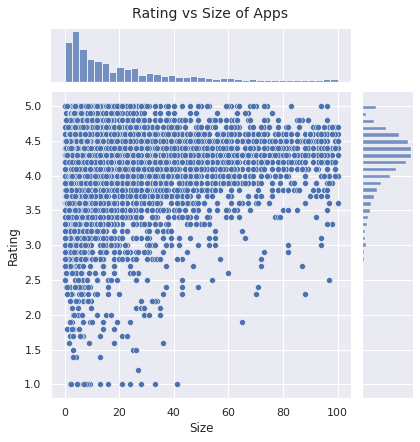

In [20]:
sns.set_style("darkgrid")
ax = sns.jointplot(play_store_df['Size'], play_store_df['Rating'])
ax.fig.suptitle("Rating vs Size of Apps", y = 1.02, fontsize=14 )

In [21]:
## Sizing distribution of top rated apps (>= 4.5) 
play_store_df_top_rated = play_store_df[play_store_df["Rating"]>=4.5]
sizing_distribution = [go.Histogram(x = play_store_df_top_rated.Size,)]
print('Average size of top rated apps = ', np.mean(play_store_df_top_rated['Size']))
#plotly.offline.iplot(sizing_distribution, filename='overall_sizing_distribution')
layout =dict(title = 'Average Size of top rated apps',
             xaxis = dict(title = 'Size of Apps'),
             yaxis = dict(title = 'Distribution'),
             )
sizing_distribution = dict(data = sizing_distribution, layout = layout)
plotly.offline.iplot(sizing_distribution, filename='overall_sizing_distribution')

Average size of top rated apps =  21.80610577798002


Most top rated apps are optimally sized between ~2MB to ~40MB - neither too light nor too bulky.

##### Sizing Strategy: Which categories have the bulkiest apps and how are they rated?

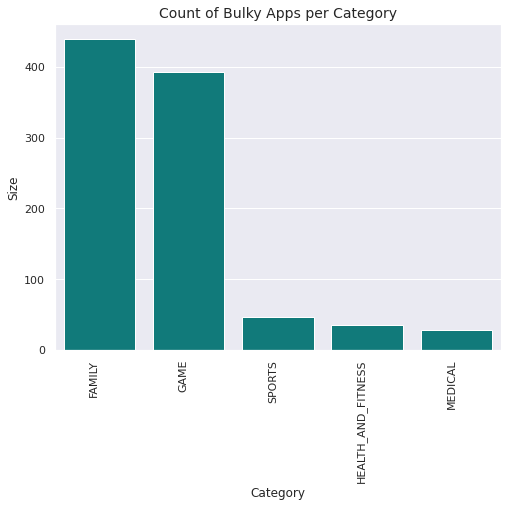

In [22]:
bulky_apps = play_store_df[play_store_df["Size"]>40]
group_category = bulky_apps.groupby("Category")["Size"].count().sort_values(ascending=False).reset_index().head()

plt.figure(figsize=(8, 6))
sns.set(font_scale=1)
sns.set_style("darkgrid")
ax = sns.barplot(x="Category", y="Size", data=group_category, color = "darkcyan")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.title('Count of Bulky Apps per Category',size = 14)
plt.savefig("Count_bulky")

In [23]:
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(play_store_df.Category))))]

subset_df = play_store_df[play_store_df.Size > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    } for category in enumerate(['GAME', 'FAMILY'])]

layout = {'title':"Rating vs Size", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

Most bulky apps ( >50MB) belong to the Game and Family category. Despite this, these bulky apps are fairly highly rated indicating that they are bulky for a purpose.

##### Sizing Strategy: How do the sizes of paid apps and free apps vary?

In [24]:
paid_apps = play_store_df[play_store_df.Type == 'Paid']

data = [{
    'x' : paid_apps['Rating'],
    'type':'scatter',
    'y' : paid_apps['Size'],
    'mode' : 'markers',
    'text' : play_store_df['Size'],
    } for t in set(paid_apps.Type)]


layout = {'title':"Rating vs Size for Paid Apps", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(255,255,255)'}

plotly.offline.iplot({'data': data, 'layout': layout})

Majority of the paid apps that are highly rated have small sizes. This means that most paid apps are designed and developed to cater to specific functionalities and hence are not bulky.
Users prefer to pay for apps that are light-weighted. A paid app that is bulky may not perform well in the market.

##### Pricing Strategy: How do App prices affect rating and number of installs?

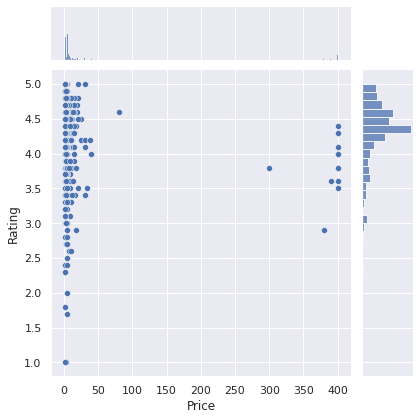

In [25]:
paid_apps = play_store_df[play_store_df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)

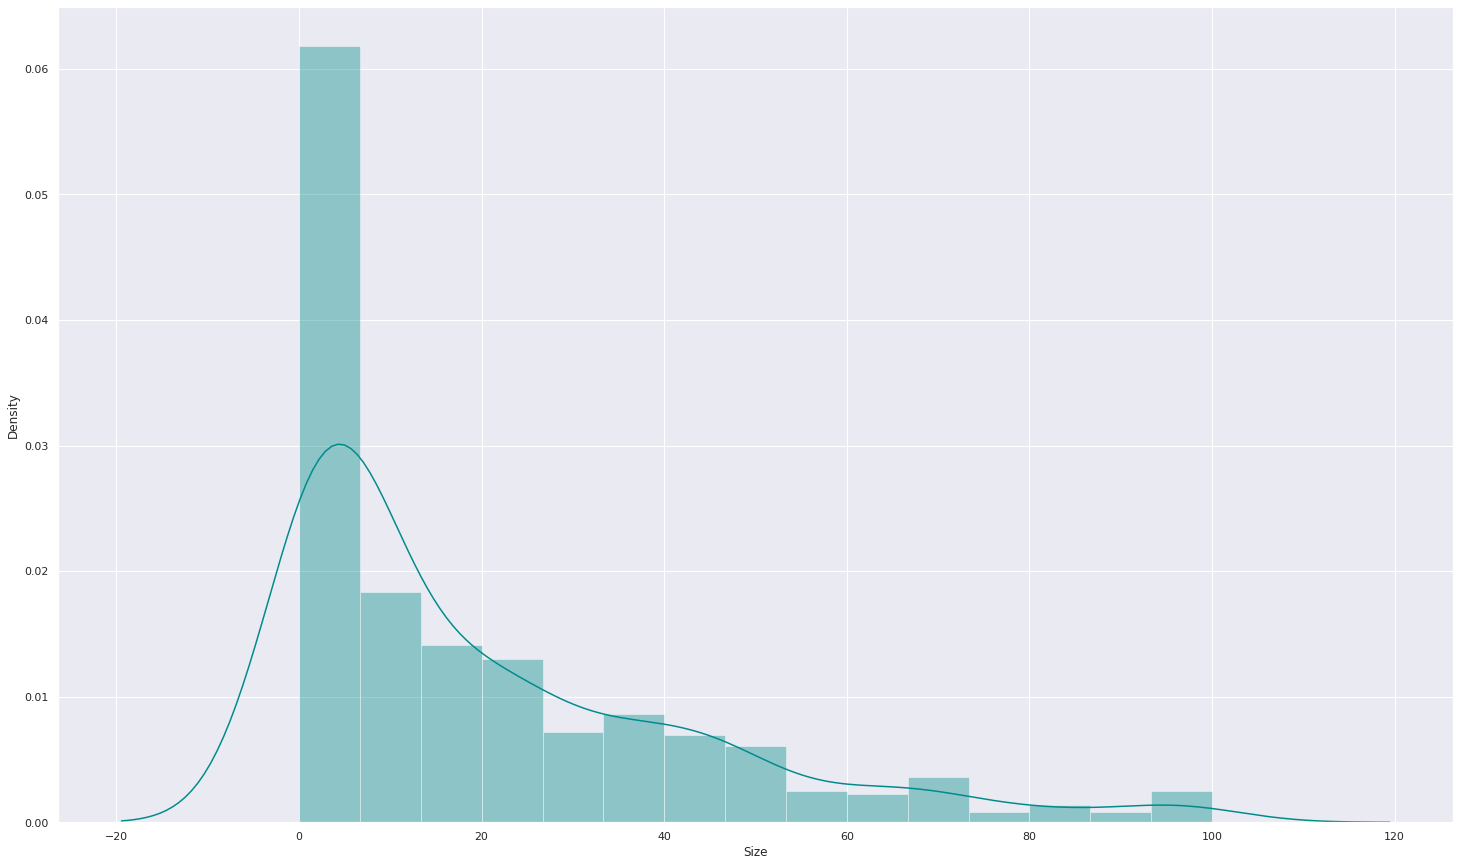

In [26]:
size_paid_apps = paid_apps['Size'].dropna()
ax = sns.distplot(size_paid_apps, color="darkcyan")

Most top rated apps are optimally priced between ~1$ to ~30$. There are only a very few apps priced above 20$.

##### Pricing trend across categories

Text(0.5, 1.0, 'App pricing trend across categories')

<Figure size 864x432 with 0 Axes>

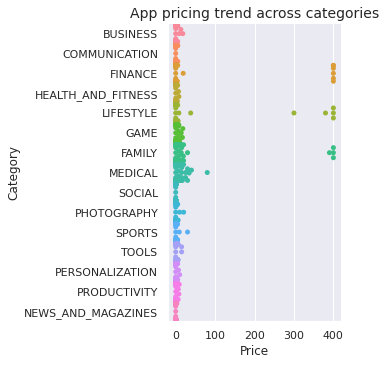

In [27]:
top_categories = play_store_df[play_store_df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS','PRODUCTIVITY','PERSONALIZATION','SPORTS','COMMUNICATION',
                                                        'HEALTH_AND_FITNESS','NEWS_AND_MAGAZINES','SOCIAL'])]

plt.figure(figsize=(12, 6))
sns.set(font_scale=1)
sns.set_style("darkgrid")
ax = sns.catplot(x="Price", y="Category", kind="swarm", data=top_categories)
plt.title('App pricing trend across categories',size = 14)


##### Rating Distribution

In [28]:
## general distribution of rating
rating_distribution = [go.Histogram(
        x = play_store_df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print('Average app rating = ', np.mean(play_store_df['Rating']))
plotly.offline.iplot(rating_distribution, filename='overall_rating_distribution')

Average app rating =  4.173243045387998


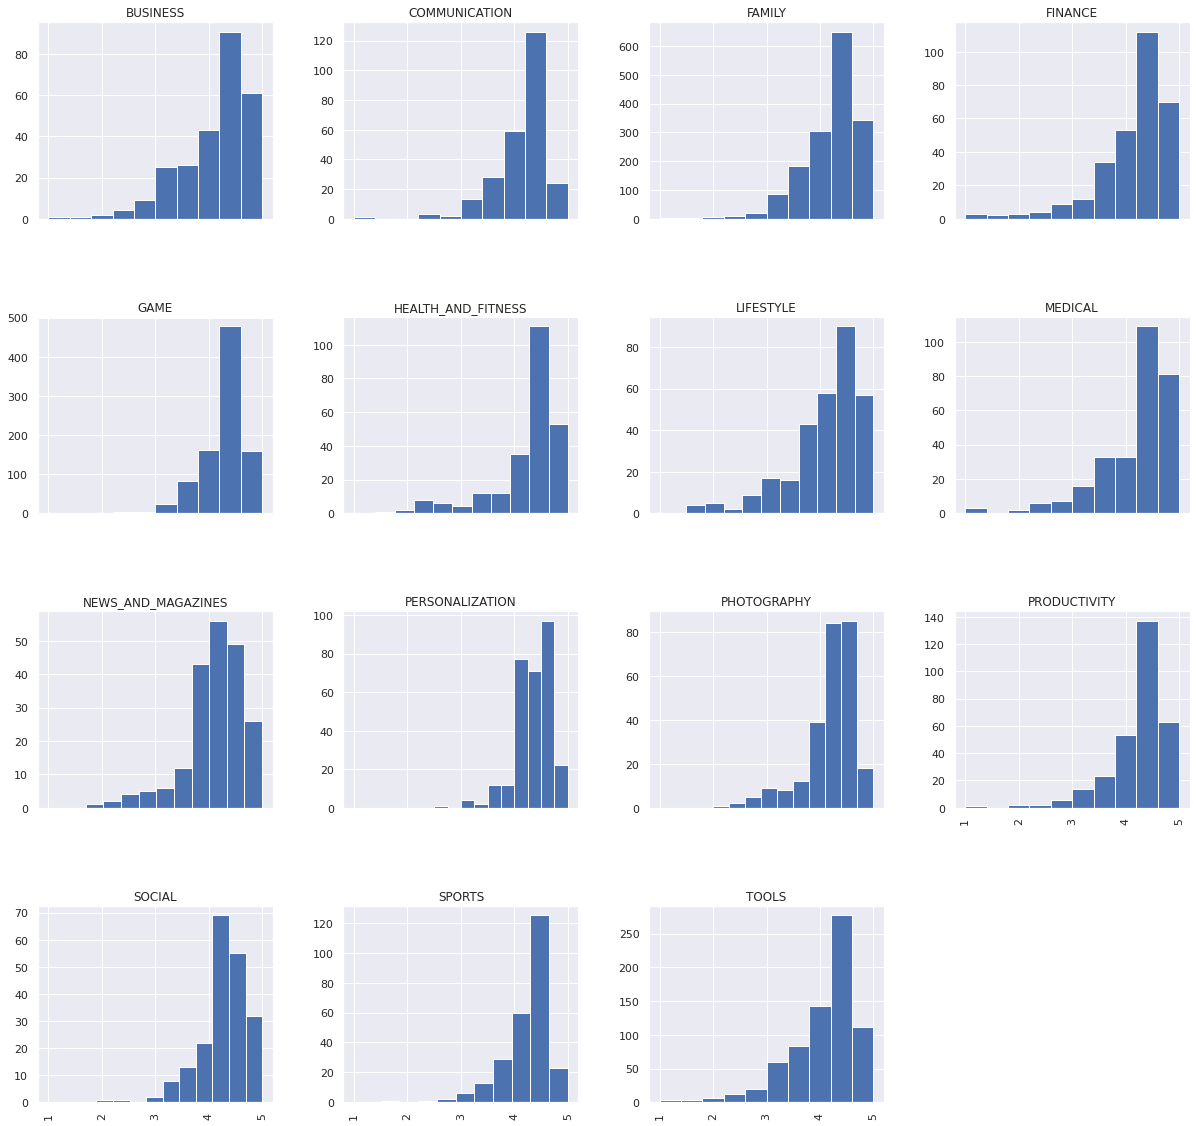

In [29]:
top_categories = play_store_df.groupby("Category").filter(lambda x: len(x) > 200).reset_index()
array = top_categories['Rating'].hist(by=top_categories['Category'], sharex=True, figsize=(20,20))

[Text(0, 0, 'BUSINESS'),
 Text(0, 0, 'COMMUNICATION'),
 Text(0, 0, 'FINANCE'),
 Text(0, 0, 'HEALTH_AND_FITNESS'),
 Text(0, 0, 'LIFESTYLE'),
 Text(0, 0, 'GAME'),
 Text(0, 0, 'FAMILY'),
 Text(0, 0, 'MEDICAL'),
 Text(0, 0, 'SOCIAL'),
 Text(0, 0, 'SHOPPING'),
 Text(0, 0, 'PHOTOGRAPHY'),
 Text(0, 0, 'SPORTS'),
 Text(0, 0, 'TRAVEL_AND_LOCAL'),
 Text(0, 0, 'TOOLS'),
 Text(0, 0, 'PERSONALIZATION'),
 Text(0, 0, 'PRODUCTIVITY'),
 Text(0, 0, 'NEWS_AND_MAGAZINES')]

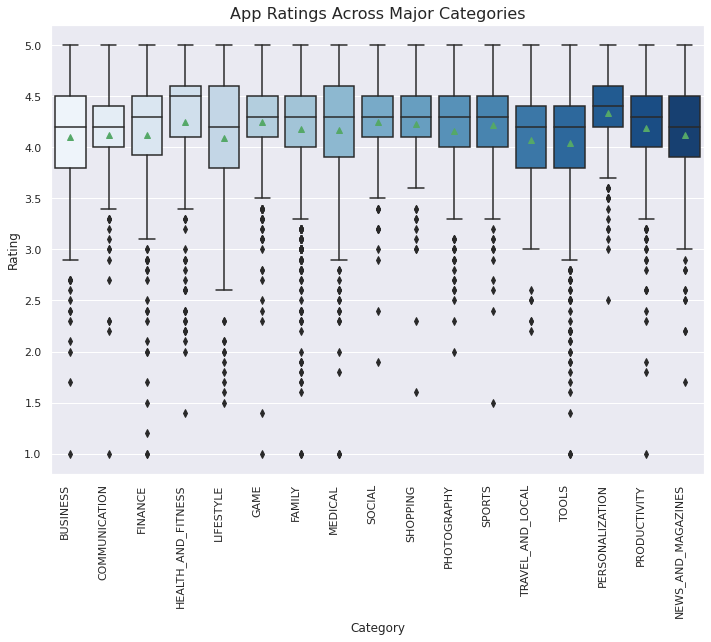

In [30]:
topcat = play_store_df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.title("App Ratings Across Major Categories", fontsize=16)
ax = sns.boxplot(x='Category', y='Rating', data=topcat, palette='Blues', showmeans=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

The rating distribution revealed that most apps perform reasonably well with an average rating of 4.17. We broke down the average rating by category to check if any category performs exceedingly good or bad. We conducted a One-way Anova Test and confirmed that the average ratings across categories is statistically different. The Health and Fitness and Books and Reference produce the best apps with 50% apps having a rating greater than 4.5. Interestingly, half of the Dating apps have a rating lower than the average.

##### Basic Sentiment Analysis - User Reviews

In [31]:
## Merge the two datasets
merged_df = play_store_df.merge(user_ratings_df, on = "App")
merged_df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,It bad >:(,Negative,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,like,Neutral,0.000,0.000000
3,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,NaN,NaN,NaN,NaN
4,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000.0,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,I love colors inspyering,Positive,0.500,0.600000


In [32]:
## Drop the NA values
merged_df = merged_df.dropna(subset=['Translated_Review'])

In [33]:
## let's see the distribution of postive, neg reviews in each category
sentiment_count = merged_df.groupby(["Category","Sentiment"]).agg({'App': 'count'}).reset_index()
sentiment_sum =  merged_df.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()
print(sentiment_sum.head())
print(sentiment_count.head())

              Category  Sentiment
0       ART_AND_DESIGN        382
1    AUTO_AND_VEHICLES        289
2               BEAUTY        338
3  BOOKS_AND_REFERENCE        651
4             BUSINESS       1082
            Category Sentiment  App
0     ART_AND_DESIGN  Negative   61
1     ART_AND_DESIGN   Neutral   62
2     ART_AND_DESIGN  Positive  259
3  AUTO_AND_VEHICLES  Negative   17
4  AUTO_AND_VEHICLES   Neutral   36


In [34]:
## we need to normalize it before plotting
new_df = sentiment_count.merge(sentiment_sum, on = "Category")
new_df["normalized_sentiment_counts"] = new_df["App"]/new_df["Sentiment_y"]
new_df.head()

,Category,Sentiment_x,App,Sentiment_y,normalized_sentiment_counts
0,ART_AND_DESIGN,Negative,61,382,0.159686
1,ART_AND_DESIGN,Neutral,62,382,0.162304
2,ART_AND_DESIGN,Positive,259,382,0.678010
3,AUTO_AND_VEHICLES,Negative,17,289,0.058824
4,AUTO_AND_VEHICLES,Neutral,36,289,0.124567


In [35]:
sentiment_count_2 = merged_df.groupby(["Category","Sentiment","Installs"]).agg({'App': 'count'}).reset_index()
sentiment_sum_2 =  merged_df.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()
sentiment_count_2.head()

,Category,Sentiment,Installs,App
0,ART_AND_DESIGN,Negative,100000.0,23
1,ART_AND_DESIGN,Negative,500000.0,22
2,ART_AND_DESIGN,Negative,1000000.0,10
3,ART_AND_DESIGN,Negative,5000000.0,3
4,ART_AND_DESIGN,Negative,10000000.0,3


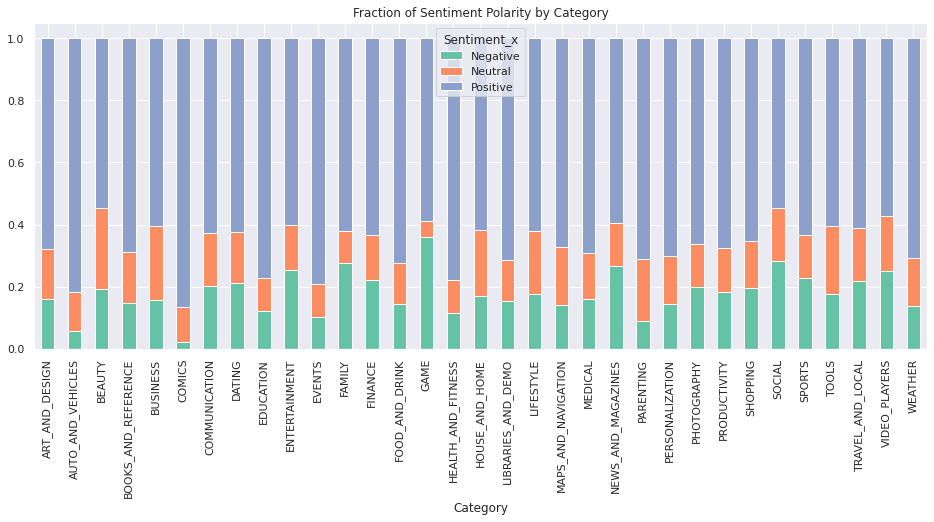

In [36]:
new_df_stack = new_df.pivot(index='Category', columns='Sentiment_x', values='normalized_sentiment_counts')
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
sns.set(palette="Set2")
new_df_stack.plot(kind='bar', stacked = True)
plt.title("Fraction of Sentiment Polarity by Category")
plt.savefig("sentiment_dist.svg", format='svg', dpi=1200)

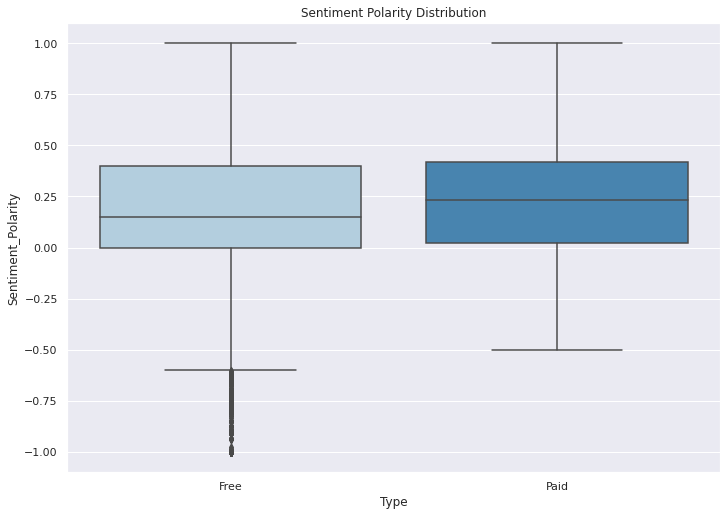

In [37]:
## sentiment polarity and free/paid apps
#sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df, palette='Blues')
title = ax.set_title('Sentiment Polarity Distribution')

We plotted the fraction of positive, negative and neutral reviews for each category and observed that the Health and Fitness apps perform the best with more than 85% positive reviews. On the other hand, Game and Social apps have a higher fraction of negative reviews. We compared the reviews between free and paid apps and found that people are harsher towards free apps whereas users are more tolerant when they are paying for it.

##### Frequency of Words in Reviews (Positive, Negative and Neutral)

We created a word cloud of commonly occurring words in positive and negative reviews and found that the words – “love”, “great” and “good” were the most commonly occurring words in the positive reviews. On the other hand, the negative words that were prevalent were “bad”, “hate” and “ads”.

In [38]:
import sys
print(sys.executable)

/usr/bin/python3


In [39]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=250, colormap="Set2")
from nltk import sent_tokenize, word_tokenize

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [40]:
## Wordcloud Function
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50, )
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')
    plt.title('Common Words in Reviews')

In [41]:
## Frequency of words in translated review column
from collections import Counter
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
import re

top_N = 100

pos_review_lower = merged_df[merged_df['Sentiment']=='Positive']['Translated_Review'].str.lower().str.cat(sep=' ')
neg_review_lower = merged_df[merged_df['Sentiment']=='Negative']['Translated_Review'].str.lower().str.cat(sep=' ')
neu_review_lower = merged_df[merged_df['Sentiment']=='Neutral']['Translated_Review'].str.lower().str.cat(sep=' ')

In [42]:
## Remove Punctuations
pos_review_remove_pun = re.sub('[^A-Za-z]+', ' ', pos_review_lower)
neg_review_remove_pun = re.sub('[^A-Za-z]+', ' ', neg_review_lower)
neu_review_remove_pun = re.sub('[^A-Za-z]+', ' ', neu_review_lower)

In [43]:
#remove all the stopwords from the text
pos_word_tokens_tags = word_tokenize(pos_review_remove_pun)
neg_word_tokens_tags = word_tokenize(neg_review_remove_pun)
neu_word_tokens_tags = word_tokenize(neu_review_remove_pun)
pos_filtered_sentence_tags = [w_tags for w_tags in pos_word_tokens_tags if not w_tags in stop]
pos_filtered_sentence_tags = []
for w_tags in pos_word_tokens_tags:
    if w_tags not in stop:
        pos_filtered_sentence_tags.append(w_tags)

neg_filtered_sentence_tags = [w_tags for w_tags in neg_word_tokens_tags if not w_tags in stop]
neg_filtered_sentence_tags = []
for w_tags in neg_word_tokens_tags:
    if w_tags not in stop:
        neg_filtered_sentence_tags.append(w_tags)
        
neu_filtered_sentence_tags = [w_tags for w_tags in neu_word_tokens_tags if not w_tags in stop]
neu_filtered_sentence_tags = []
for w_tags in neu_word_tokens_tags:
    if w_tags not in stop:
        neu_filtered_sentence_tags.append(w_tags)

In [44]:
# Remove characters which have length less than 2  

pos_without_single_chr_rev = [word_tags for word_tags in pos_filtered_sentence_tags if len(word_tags) > 2]
neg_without_single_chr_rev = [word_tags for word_tags in neg_filtered_sentence_tags if len(word_tags) > 2]
neu_without_single_chr_rev = [word_tags for word_tags in neu_filtered_sentence_tags if len(word_tags) > 2]

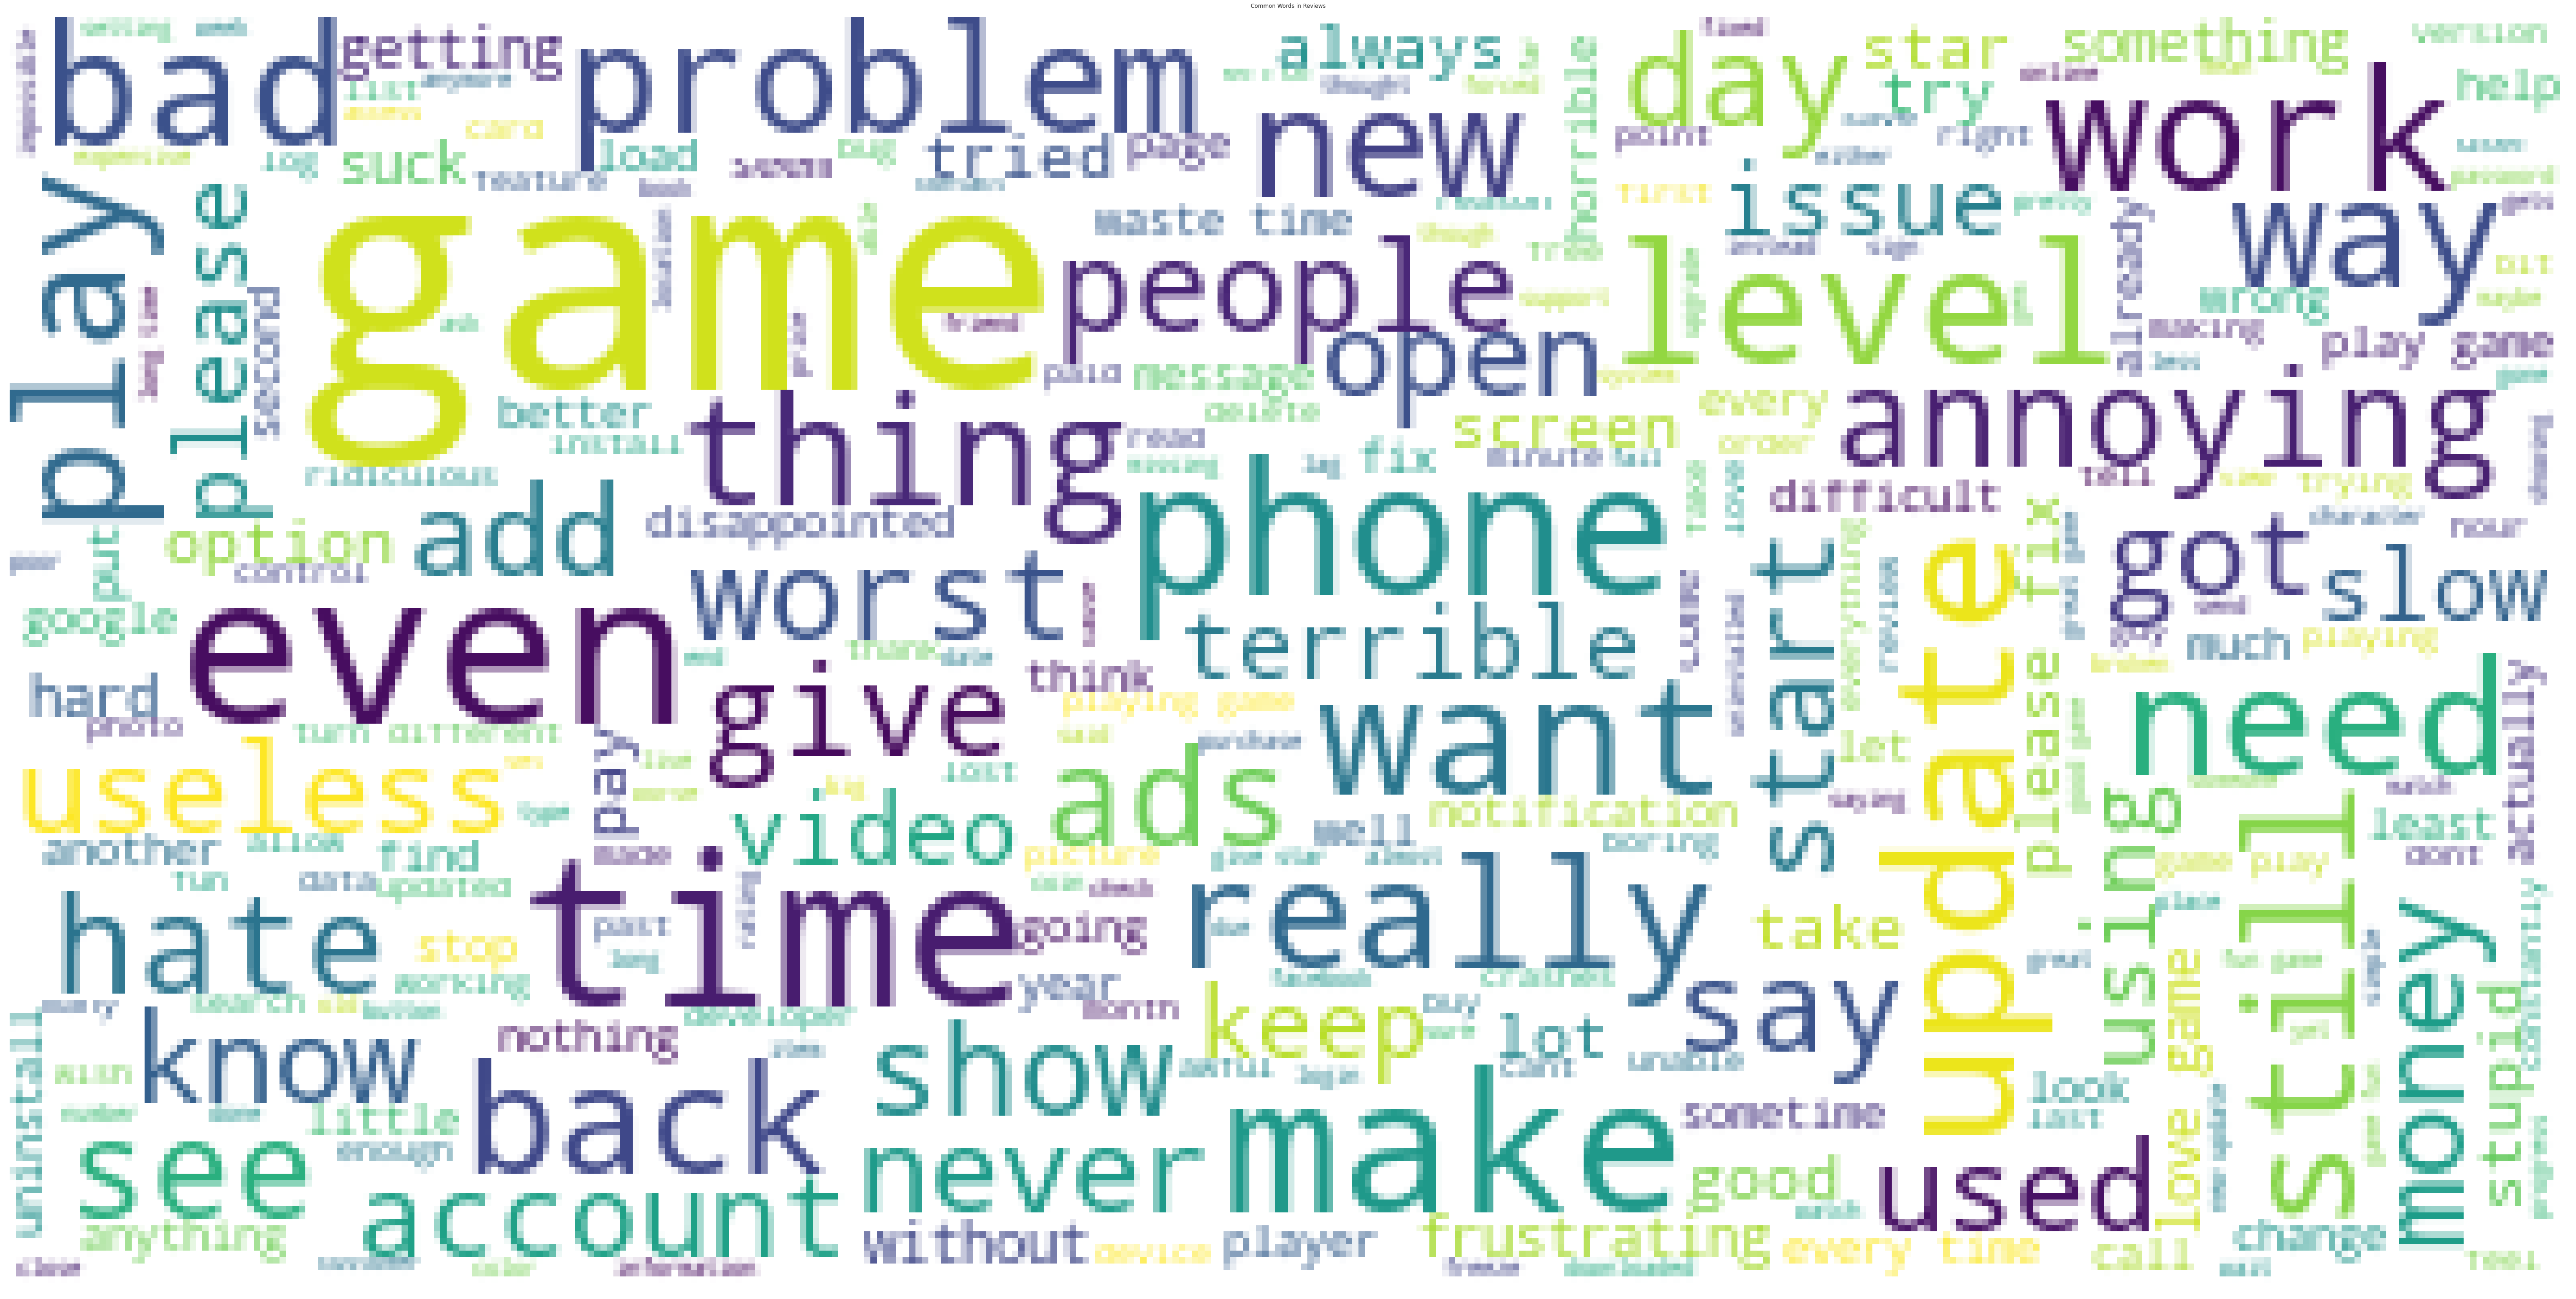

In [45]:
## Wordcloud of Negative Reviews
wc(neg_without_single_chr_rev,'white','Common Words' )

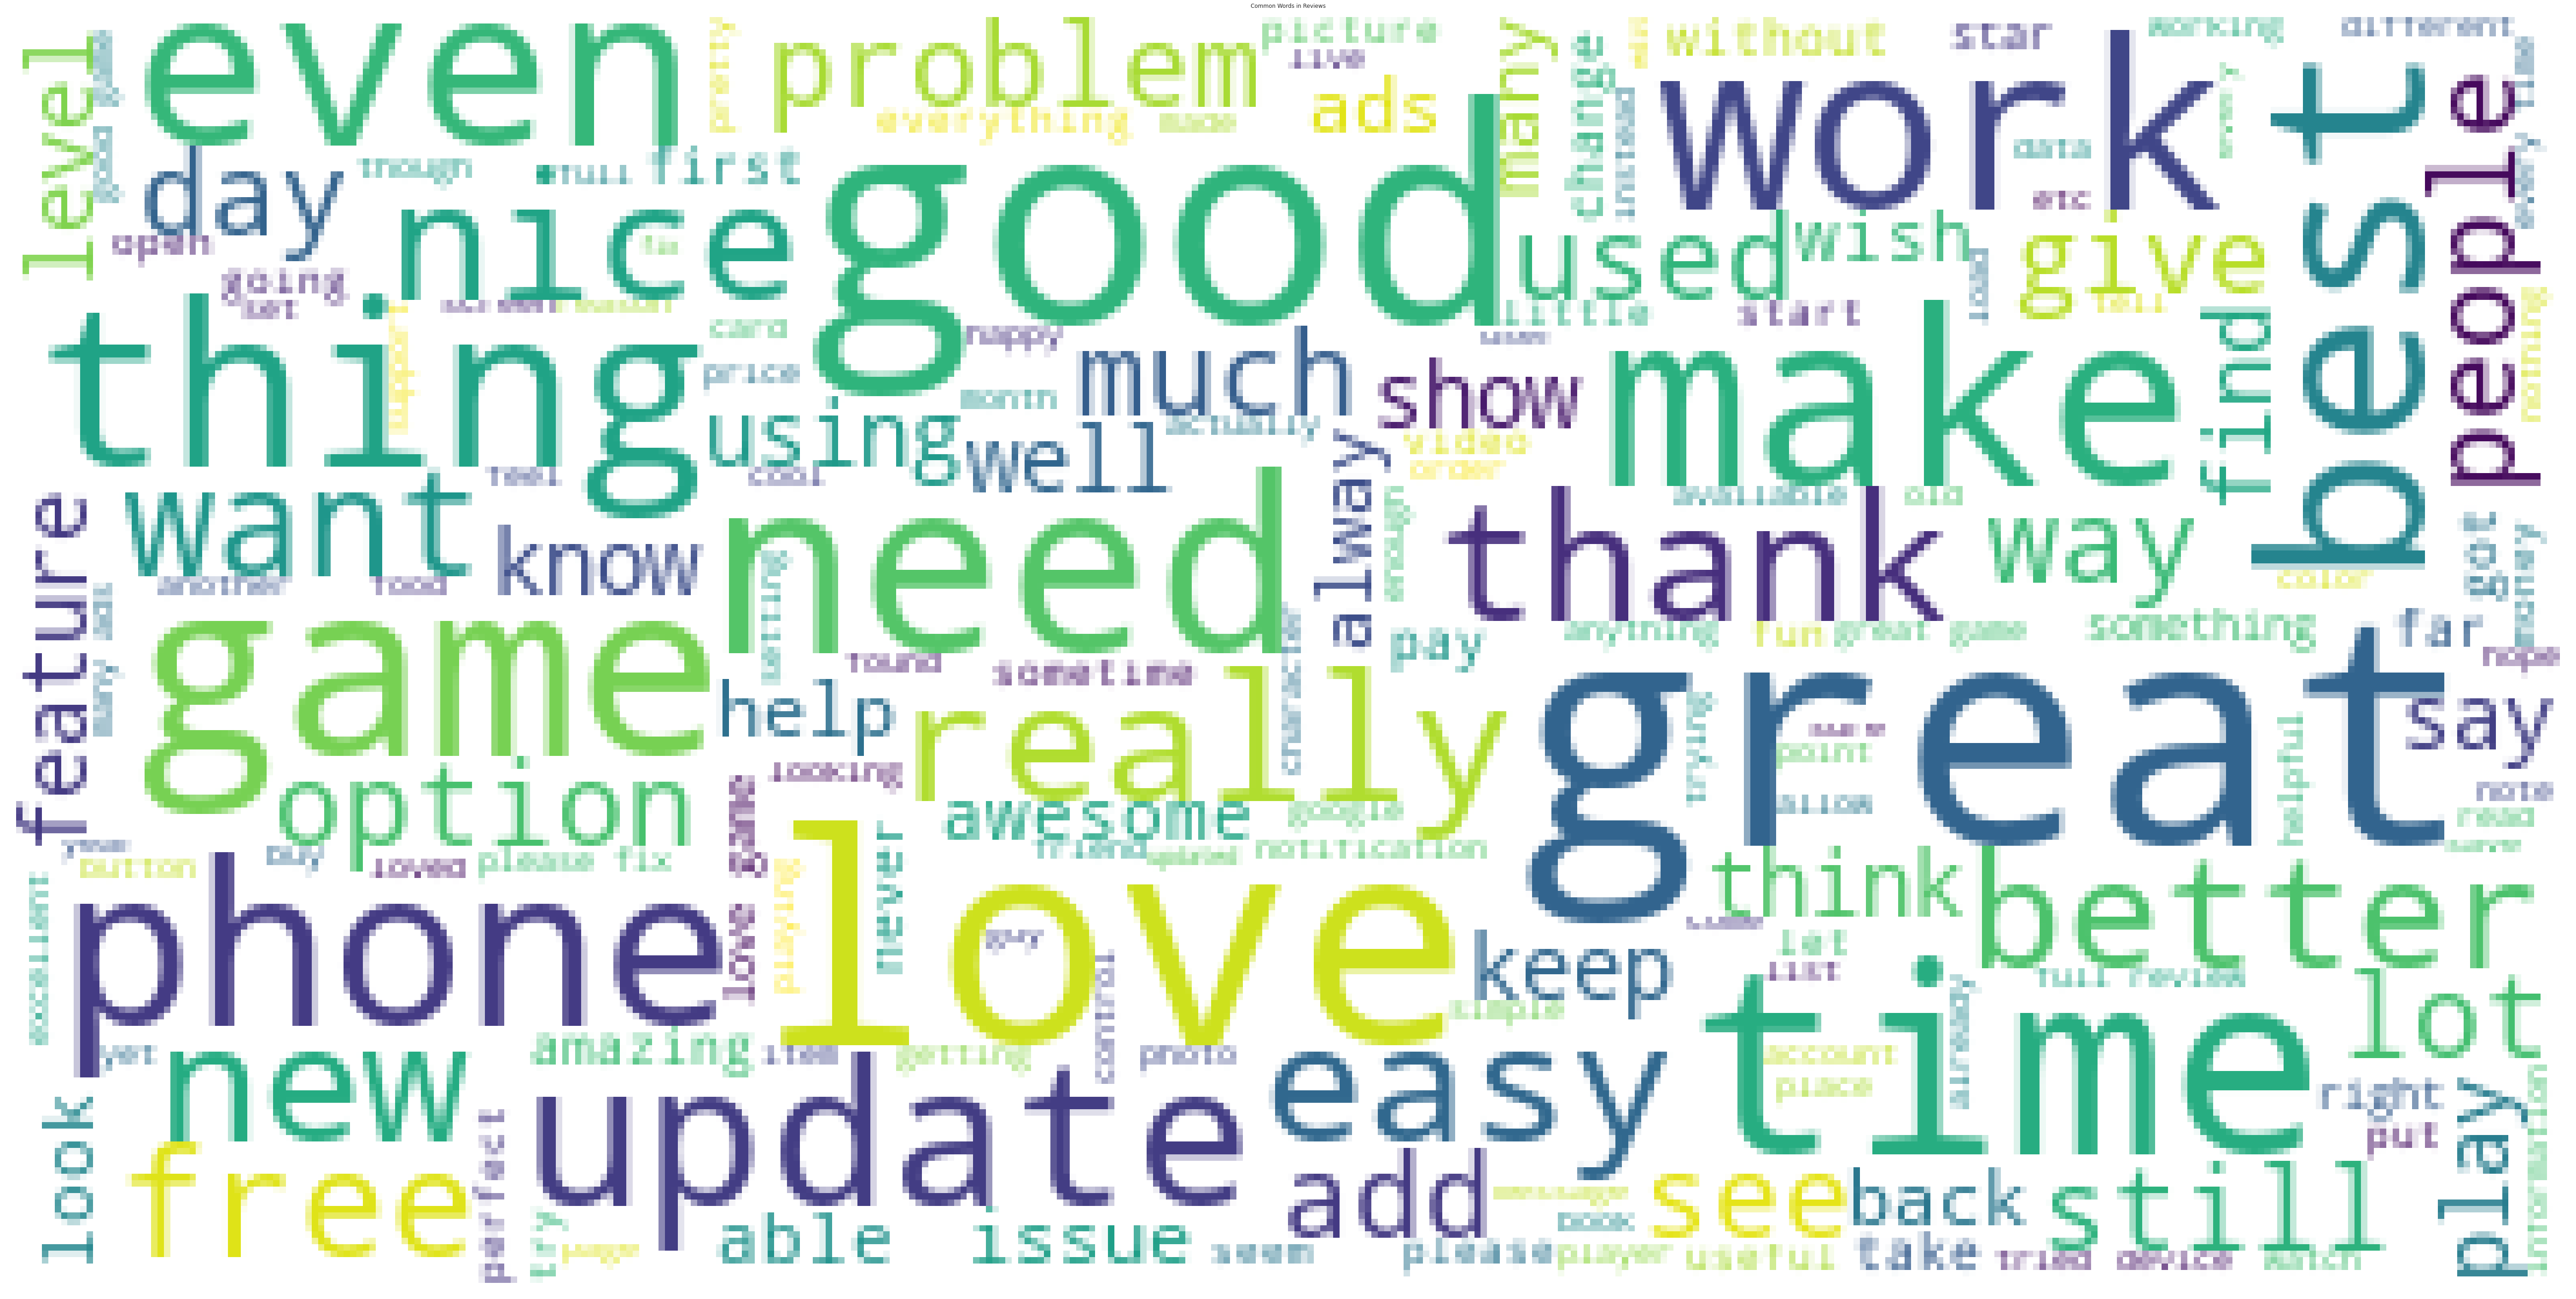

In [46]:
## Wordcloud of Positive Reviews
wc(pos_without_single_chr_rev,'white','Common Words' )

However, this did not provide any tangible insights. Our aim was to analyse the reviews and get a better idea of the common issues that people face with apps or the attributes that make an app popular.
To accomplish this, we proceeded to extract phrases (pairs of words) to get a better understanding that will support our analysis.

In [47]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=250, colormap="Set2")
from nltk import sent_tokenize, word_tokenize

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher','please','love','it','the','i',
              'I','my','like','really','every','would','even','though','game','review']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 300,  max_font_size = 50, )
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')
    plt.title('Common Phrases in Reviews')

In [49]:
def pair_split(x):
    words = re.sub('[^A-Za-z_]+', ' ', x)
    words = words.split()
    words_new = [x for x in words if x not in stop]
    if len(words_new) == 1:
        return words_new
    else:
        pairs = [words_new[i]+'_'+words_new[i+1] for i in range(len(words_new)-1)]
        return pairs

In [50]:
## Frequency of words in translated review column
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re

top_N = 100

## Get every pair of words from the reviews

pos_review_lower = merged_df[merged_df['Sentiment']=='Positive']['Translated_Review'].str.lower().apply(pair_split).apply(lambda x: " ".join(x)).str.cat(sep=' ')
neg_review_lower = merged_df[merged_df['Sentiment']=='Negative']['Translated_Review'].str.lower().apply(pair_split).apply(lambda x: " ".join(x)).str.cat(sep=' ')
neu_review_lower = merged_df[merged_df['Sentiment']=='Neutral']['Translated_Review'].str.lower().apply(pair_split).apply(lambda x: " ".join(x)).str.cat(sep=' ')

pos_review_lower_rem = pos_review_lower.split(' ')
pos_review_lower_rem = [a for a  in pos_review_lower_rem if a.find('_') >0]
pos_review_remove_pun = " ".join(pos_review_lower_rem)

neg_review_lower_rem = neg_review_lower.split(' ')
neg_review_lower_rem = [a for a  in neg_review_lower_rem if a.find('_') >0]
neg_review_remove_pun = " ".join(neg_review_lower_rem)

neu_review_lower_rem = neu_review_lower.split(' ')
neu_review_lower_rem = [a for a  in neu_review_lower_rem if a.find('_') >0]
neu_review_remove_pun = " ".join(neu_review_lower_rem)

In [51]:
pos_word_tokens_tags = word_tokenize(pos_review_remove_pun)
neg_word_tokens_tags = word_tokenize(neg_review_remove_pun)
neu_word_tokens_tags = word_tokenize(neu_review_remove_pun)
pos_filtered_sentence_tags = [w_tags for w_tags in pos_word_tokens_tags if not w_tags in stop]
pos_filtered_sentence_tags = []
for w_tags in pos_word_tokens_tags:
    if w_tags not in stop:
        pos_filtered_sentence_tags.append(w_tags)

neg_filtered_sentence_tags = [w_tags for w_tags in neg_word_tokens_tags if not w_tags in stop]
neg_filtered_sentence_tags = []
for w_tags in neg_word_tokens_tags:
    if w_tags not in stop:
        neg_filtered_sentence_tags.append(w_tags)
        
neu_filtered_sentence_tags = [w_tags for w_tags in neu_word_tokens_tags if not w_tags in stop]
neu_filtered_sentence_tags = []
for w_tags in neu_word_tokens_tags:
    if w_tags not in stop:
        neu_filtered_sentence_tags.append(w_tags)

In [52]:
# Remove characters which have length less than 2  

pos_without_single_chr_rev = [word_tags for word_tags in pos_filtered_sentence_tags if len(word_tags) > 2]
neg_without_single_chr_rev = [word_tags for word_tags in neg_filtered_sentence_tags if len(word_tags) > 2]
neu_without_single_chr_rev = [word_tags for word_tags in neu_filtered_sentence_tags if len(word_tags) > 2]


In [53]:
from collections import Counter
counts = Counter(neg_without_single_chr_rev)
count_top30 = counts.most_common(10)
count_top30

[('waste_time', 200),
 ('long_time', 96),
 ('worst_ever', 78),
 ('many_ads', 75),
 ('give_stars', 75),
 ('last_update', 71),
 ('new_update', 70),
 ('google_play', 61),
 ('go_back', 58),
 ('fix_problem', 53)]

Text(0.5, 1.0, 'Common Phrases in Negative Reviews')

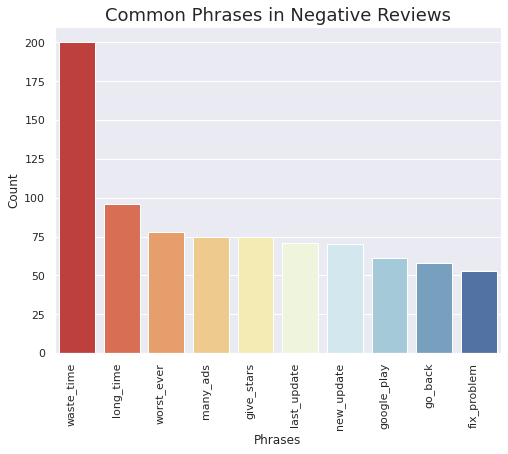

In [54]:
count_top30_df = pd.DataFrame(count_top30, columns=["Phrases","Count"])
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)
category_plot = sns.barplot(x="Phrases",y ="Count",data=count_top30_df, palette = "RdYlBu")
category_plot.set_xticklabels(category_plot.get_xticklabels(), rotation=90, ha="right")
plt.title('Common Phrases in Negative Reviews',size = 18)

In [55]:
from collections import Counter
counts = Counter(pos_without_single_chr_rev)
count_top30 = counts.most_common(10)
count_top30

[('many_ads', 324),
 ('much_better', 186),
 ('user_friendly', 156),
 ('latest_update', 155),
 ('first_time', 148),
 ('free_version', 147),
 ('best_ever', 138),
 ('highly_recommend', 134),
 ('new_update', 128),
 ('wish_could', 128)]

Text(0.5, 1.0, 'Common Phrases in Positive Reviews')

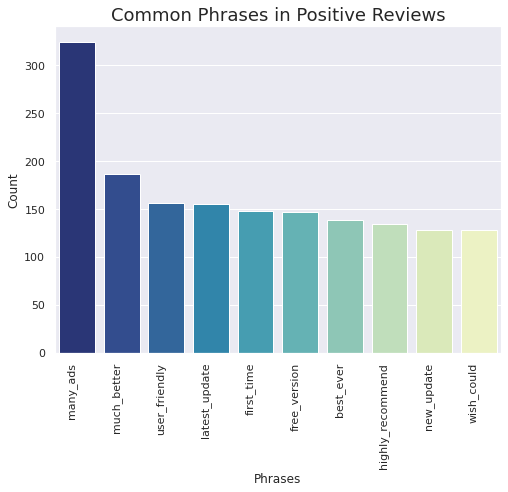

In [56]:
count_top30_df = pd.DataFrame(count_top30, columns=["Phrases","Count"])
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)
category_plot = sns.barplot(x="Phrases",y ="Count",data=count_top30_df, palette = "YlGnBu_r")
category_plot.set_xticklabels(category_plot.get_xticklabels(), rotation=90, ha="right")
plt.title('Common Phrases in Positive Reviews',size = 18)

We extracted phrases from the reviews and observed that positive reviews had phrases like “user friendly”, “free version”, “works great” and “highly recommend”. The negative reviews contained phrases like “waste time”, “many ads”, “spend money” and “takes forever”. We can see that loading time and ads were one of the main concerns amongst users. On the other hand, usability is one of the reasons that users give positive reviews.